# References

- paper
    - title: Toward Controlled Generation of Text
    - link: https://arxiv.org/pdf/1703.00955.pdf
- reference codes
    - OFFICIAL: https://github.com/asyml/texar/tree/master/examples/text_style_transfer
    - https://github.com/wiseodd/controlled-text-generation
    - https://github.com/GBLin5566/toward-controlled-generation-of-text-pytorch

# 결과는?
- 좋지 않았다...
- Generator가 말이 되는 문장을 잘 생성하긴 함. 그런데 sentiment를 바꾸면 fluency가 너무 떨어짐

# Model overview
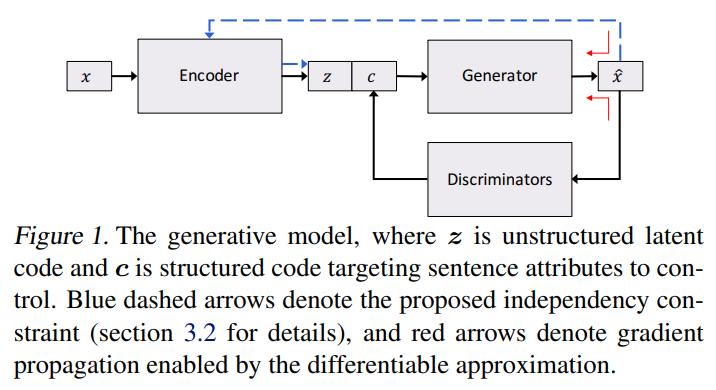
- $z$ is just a common 'unstructured' latent vector in a common VAE.
- $c$ is a 'structured' vector (called attribute code) related to the text style (e.g., sentiment).
    * $c$ does not need to be one attribute, instead several vectors.

# Model details
- The basic architecture of the model is LSTM-VAE.
    - and thus, encoder $E$ & generator $G$ are LSTM_RNN.
- $\hat{x}_t$, predicted token in $G$, follows $softmax(o_t/\tau)$
    - $o_t$ is the logit of the token at $t$ step in training.
    - $\tau$ is the annealing temperature which is set to 1 initially and decreases to zero as the training progresses.
    - The decreasing $\tau$ makes $o_t/\tau$ peaking, and thus $\hat{x}_t$ gets more deterministic.
- $G$ generates discrete tokens (i.e., one-hot vectors), which are not differentiable for the discriminator $D$.
    - Thus, $G$ should output rather 'continuous approximations' of the one-hot vectors.
<br><hr><br>
- The $E$ loss
    1. VAE loss: just a common VAE loss.
- The $G$ loss
    1. VAE loss: just a common VAE loss <-- surely shared with $E$.
    2. $c, D$ loss: loss occuring in the process, generated senetence --> $D$ --> $c$.
        * A regulization parameter $\lambda_c$ is mutiplied.
        * Goal: to ensure that $G$ generates sentences suitable for $c$.
    2. $z, E$ loss: loss occuring in the process, generated senetence --> $E$ --> $z$.
        * A regulization parameter $\lambda_z$ is mutiplied.
        * Goal: to ensure that $G$ generates sentences that can cover some implicit attributes contained in $z$.
- The $D$ loss
    * 아래 그림을 보면 sleep phase에서 random sampling from prior를 가지고 생성한 문장에서 업데이트한다...!
        * Thus, no pretraining
    1. random sampling $z$ & $c$ from the priors, $p(z)$ & $p(c)$  <---  I will use $N(0,I)$ & $Dirichlet(1)$, respectively.
    2. Generate sentence, $\hat{x}$ ~ $G(z,c)$.
    2. Supervision loss: $D(\hat{x})$ --> $c$

# Wake-Sleep Algorithm
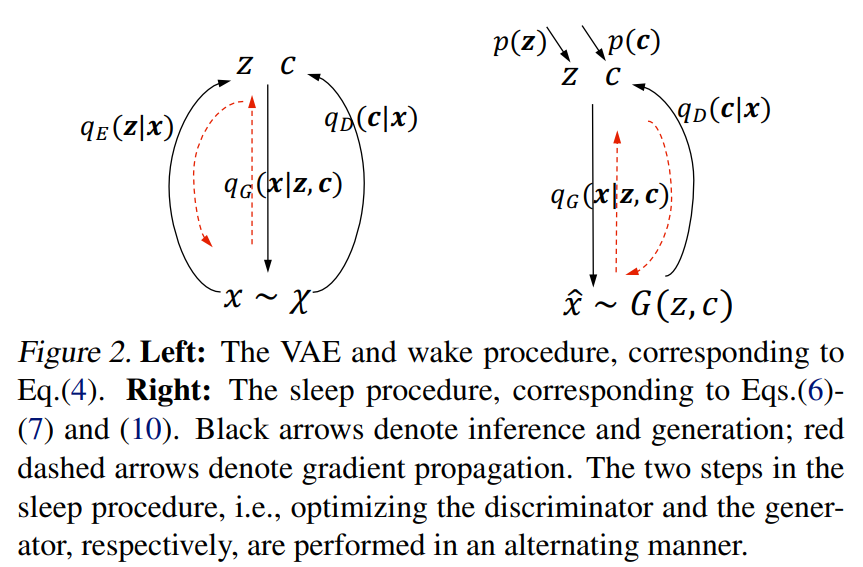

# Training plan summary
- Pretrain a basic VAE with a big corpus (no label)
    * $c$ 는 일단 prior $p(c)$에서 샘플링해서 씀.
- VAE 학습 이후에 $D$와 $G$ & $E$를 번갈아 가면서 학습
    - wake pahse (VAE)
        - $E$ & $G$ training
            - 문장을 $E$에 투입해서 $z$를 get --> KLD
            - 문장을 $D$에 투입해서 $c$를 get
            - $(z, c)$를 $G$에 투입해서 reconstruct --> $E$ & $G$ 학습

    - sleep phase
        - $G$ training
            - $p(z)$ & $p(c)$를 이용해서 랜덤 문장 생성
            - 문장을 다시 $E$에 투입해서 $\hat{z}$를 get (단 embedding 형태의 reconstruction 사용!)
            - 문장을 다시 $D$에 투입해서 $\hat{c}$를 get (단 embedding 형태의 reconstruction 사용!)
            - $(z, c)$와 $(\hat{z}, \hat{c})$ 비교해서 $G$ 학습
        - $D$ training
            - loss s
                - 문장을 $D$에 투입해서 레이블을 맞추는 평범한 과제
            - loss u
                - $p(z)$ & $p(c)$에서 샘플링한 $(z, c)$를 $G$에 투입해서 문장 $\hat{x}$ 생성
                - $\hat{x}$를 $D$에 투입해서 $c$ 예측

# Environment
- WSL2 (Ubunutu 20.04) + docker
- docker image: pytorch 1.12.0
- GPU: RTX 3060 laptop (6 GB)
    - required GPU memory: no more than 4.2 GB

# Data

In [1]:
### Load a pretrained w2v model
## Download a pretrained Korean w2v model from https://github.com/Kyubyong/wordvectors <-- Thank you!
import gensim

print(f"gensim version :: {gensim.__version__}    <---- must use 3.8.x to load a binary file")
w2v_model = gensim.models.Word2Vec.load("ko.bin")
print("shape :: {}".format(w2v_model.wv.vectors.shape))

gensim version :: 3.8.3    <---- must use 3.8.x to load a binary file
shape :: (30185, 200)


In [2]:
### Download the datasets // Thank you Naver!
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [3]:
### Load a dataset // NSMC
import pandas as pd

PRETRAIN_SIZE = 100_000
TRAIN_SIZE = 50_000
TEST_SIZE = 10_000

pretrainset = pd.read_csv("ratings_train.txt", sep="\t")[ : PRETRAIN_SIZE]
trainset = pd.read_csv("ratings_train.txt", sep="\t")[PRETRAIN_SIZE : PRETRAIN_SIZE+TRAIN_SIZE]
testset = pd.read_csv("ratings_test.txt", sep="\t")[ : TEST_SIZE]
print("dataset size\n\tpretrain :: {}\n\ttrain :: {}\n\ttest :: {}".format(len(pretrainset), len(trainset), len(testset)))
trainset.tail(3)

dataset size
	pretrain :: 100000
	train :: 50000
	test :: 10000


,id,document,label
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [4]:
pretrainset["label"] = pretrainset["label"].apply(lambda x: "pos" if x==1 else "neg")
trainset["label"] = trainset["label"].apply(lambda x: "pos" if x==1 else "neg")
testset["label"] = testset["label"].apply(lambda x: "pos" if x==1 else "neg")

In [5]:
pretrainset["flattened_label"] = pretrainset["label"].apply(lambda x: [1,0] if x=="neg" else [0,1])
trainset["flattened_label"] = trainset["label"].apply(lambda x: [1,0] if x=="neg" else [0,1])
testset["flattened_label"] = testset["label"].apply(lambda x: [1,0] if x=="neg" else [0,1])

In [6]:
### Tokenization // Since the pretrained w2v model is based on Kkma, let us use it.
from konlpy.tag import Kkma
from tqdm import tqdm

kkma = Kkma() # good tokenizer

SEQ_LEN = 30

def _tokenize(text, maxlen:int=SEQ_LEN):  
    try:
        tokens = kkma.morphs(str(text))
        tokens = ["<BOS>"] + tokens + ["<EOS>"]
    except:
        tokens = ["<BOS>", "<UNK>", "<EOS>"]
        
    if len(tokens) < maxlen:
        tokens += ["<PAD>"] * (maxlen - len(tokens))
    elif len(tokens) == maxlen:
        pass
    elif len(tokens) > maxlen:
        tokens = tokens[:maxlen]
    else:
        print("a critical logic failure has happened in your current universe. immediate escape permitted. 🤞")
    
    return tokens

tqdm.pandas() # good progress bar
pretrainset["tokens"] = pretrainset["document"].progress_apply(lambda x: _tokenize(x))
trainset["tokens"] = trainset["document"].progress_apply(lambda x: _tokenize(x))
testset["tokens"] = testset["document"].progress_apply(lambda x: _tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:37<00:00, 63.38it/s]


In [7]:
from tqdm.auto import tqdm as a_tqdm

vocab = []
for idx, row in a_tqdm(pretrainset.iterrows()):
    vocab.extend(list(set(row["tokens"])))
    vocab = list(set(vocab))
for idx, row in a_tqdm(trainset.iterrows()):
    vocab.extend(list(set(row["tokens"])))
    vocab = list(set(vocab))
for idx, row in a_tqdm(testset.iterrows()):
    vocab.extend(list(set(row["tokens"])))
    vocab = list(set(vocab))

vocab.remove("<PAD>")
vocab.remove("<UNK>")
vocab.remove("<BOS>")
vocab.remove("<EOS>")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
### Use words in the pretrained W2V model, and drop the rest.
print(len(vocab))
vocab = [v for v in vocab if v in w2v_model.wv.index2word]
print(len(vocab))

40577
17479


In [9]:
### Create word vectors for embedding layers.
import torch

vectors = torch.Tensor(0, 200)
for v in vocab:
    vector = torch.tensor(w2v_model.wv[v])
    vectors = torch.vstack([vectors, vector])

## Add special tokens to the vocab and word vectors
vocab = ["<PAD>", "<UNK>", "<BOS>", "<EOS>"] + vocab
vectors = torch.vstack([torch.zeros(4,200), vectors]) # zero vectors for <PAD>, <UNK>, <BOS>, and <EOS> <-- trained later

In [10]:
index2word = dict(enumerate(vocab))
word2index = dict(zip(index2word.values(), index2word.keys()))

In [44]:
PAD = 0; UNK = 1; BOS = 2; EOS = 3;

In [11]:
### Indexing
def _indexing(tokens):
    output = []
    for t in tokens:
        if t in vocab:
            output.append(word2index[t])
        else:
            output.append(UNK) # <UNK> index
            
    return output
            
    
pretrainset["word_idx"] = pretrainset["tokens"].progress_apply(_indexing)
trainset["word_idx"] = trainset["tokens"].progress_apply(_indexing)
testset["word_idx"] = testset["tokens"].progress_apply(_indexing)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.96it/s]


In [12]:
### Get the pretrained vectors from the model, and try them for an nn.Embedding layer.
import torch.nn as nn

emb_layer = nn.Embedding.from_pretrained(vectors, padding_idx=PAD)

## the first sentence in the pretrainset.
print(pretrainset["document"][0], "\n")
print(pretrainset["tokens"][0],  "\n")
print(pretrainset["word_idx"][0],  "\n")
print(emb_layer(torch.LongTensor(pretrainset["word_idx"][0])).size(), "   <-- (padded_length, word_vector_depth)\n")
print(emb_layer(torch.LongTensor(pretrainset["word_idx"][0])))

아 더빙.. 진짜 짜증나네요 목소리 

['<BOS>', '아', '아', '더빙', '..', '진짜', '짜증나', '네요', '목소리', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

[2, 16826, 16826, 9485, 15578, 6840, 1, 1925, 3264, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

torch.Size([30, 200])    <-- (padded_length, word_vector_depth)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0707,  1.0266,  2.5726,  ...,  0.0709, -0.3189, -2.2601],
        [-0.0707,  1.0266,  2.5726,  ...,  0.0709, -0.3189, -2.2601],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


# Data Loader

In [13]:
## Create a dataset.
from torch.utils.data import Dataset

class NSMCDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        word_idx = self.data["word_idx"].iloc[idx]
        word_idx = torch.LongTensor(word_idx)
        label = self.data["flattened_label"].iloc[idx]
        label = torch.FloatTensor([label])
        return word_idx, label

In [14]:
### Create dataloaders.
from torch.utils.data import DataLoader

BATCH_SIZE = 64 # Determine the batch size here.

pretrain_ds = NSMCDataset(data=pretrainset)
pretrain_dl = DataLoader(pretrain_ds, batch_size=BATCH_SIZE, shuffle=True)

train_ds = NSMCDataset(data=trainset)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = NSMCDataset(data=testset)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape, "  <--- squeeze the 1-dim later")

torch.Size([64, 30])
torch.Size([64, 1, 2])   <--- squeeze the 1-dim later


# Modules

In [15]:
import torch.nn.functional as F

In [16]:
### Set the device.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set GPU number if needed.
print(DEVICE)

cuda


In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        num_layers=1,
        hidden_size=300,
        bidirectional=False,
        lstm_dropout=0.1,
        dropout=0.1,
        latent_size=300, # The latent size and the hidden size should be equal for the model's brevity.
    ):
        super().__init__()
        ## Hyperparameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.latent_size = latent_size
        ## Factors
        self.vocab_size = vectors.size(0)
        self.word_vector_size = vectors.size(1)
        self.hidden_factor = num_layers * (2 if bidirectional else 1)
        ## Layers
        self.word_id_to_embedding = nn.Embedding.from_pretrained(vectors, padding_idx=PAD, freeze=False)
        self.lstm = nn.LSTM(
            input_size=self.word_vector_size, 
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_dropout,
        )
        self.dropout = nn.Dropout(dropout)
        ## Extract latent Gaussian parameters
        self.encode_mu = nn.Linear(hidden_size, latent_size)
        self.encode_log_sigma = nn.Linear(hidden_size, latent_size)
        

    def _reparameterization_sampling(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn(size=sigma.size(), requires_grad=False).to(DEVICE)
        self.z_mu = mu
        self.z_log_sigma = log_sigma
        
        return mu + sigma * epsilon
    
    
    def forward(self, word_ids, hidden=None, embedding_input=False):
        ## Embedding block
        if embedding_input:
            embedding = word_ids
        else:
            embedding = self.word_id_to_embedding(word_ids)
        embedding = self.dropout(embedding)
        
        ## LSTM block
        if hidden: # When an initial hidden state is given.
            _, (final_hidden, final_cell) = self.lstm(embedding, hidden)
        else: # When no initial hidden state is given, zeros are used by default.
            _, (final_hidden, final_cell) = self.lstm(embedding)
                
        ## Obtain mu & log sigma from the final hidden state.
        mu = self.encode_mu(final_hidden)
        log_sigma = self.encode_log_sigma(final_hidden)
        
        ## Reparameterization on the final hidden state,
        reparameterized_final_hidden = self._reparameterization_sampling(mu, log_sigma)
        
        return (reparameterized_final_hidden, final_cell)

In [18]:
class Generator(nn.Module):
    def __init__(
        self,
        num_layers=1,
        hidden_size=300,
        bidirectional=False,
        lstm_dropout=0.1,
        dropout=0.1,
        latent_size=300, # should be equal to the hidden size for the model's brevity.
        c_size=2,
    ):
        super().__init__()
        ## Hyperparameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.latent_size = latent_size
        ## Factors
        self.c_size=c_size
        self.vocab_size = vectors.size(0)
        self.word_vector_size = vectors.size(1)
        self.hidden_factor = num_layers * (2 if bidirectional else 1)
        ## Layers
        self.word_id_to_embedding = nn.Embedding.from_pretrained(vectors, padding_idx=PAD, freeze=False)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            input_size=self.word_vector_size, 
            hidden_size=hidden_size + c_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_dropout,
        )
        self.output_to_embedding = nn.Sequential(
            nn.Linear((hidden_size + c_size) * (2 if bidirectional else 1), self.word_vector_size),
            nn.LeakyReLU(),
        )
        self.embedding_to_one_hot = nn.Linear(self.word_vector_size, self.vocab_size)
        self.embedding_to_one_hot.weight = self.word_id_to_embedding.weight
    
    
    def _init_cell(self, batch_size):
        c0 = torch.empty(self.hidden_factor, batch_size, self.hidden_size, requires_grad=False).to(DEVICE)
        torch.nn.init.zeros_(c0)
        
        return c0
    
    
    def _attr_c_prior_sampler(self, batch_size, one_hot=True):
        dirichlet_parameter = torch.ones(batch_size, self.c_size)
        sampler = torch.distributions.dirichlet.Dirichlet(concentration=dirichlet_parameter)
        samples = sampler.sample().to(DEVICE)
        if one_hot==True:
            samples = torch.argmax(samples, dim=1)
            samples = F.one_hot(samples, num_classes=self.c_size)
            samples = samples.float()
        
        return samples # "requires_grad" for samplig is False by default.
    
    
    def _z_prior_sampler(self, batch_size):
        
        return torch.randn(batch_size, self.hidden_size).to(DEVICE)
        
        
    def forward(self, previous_word_ids, hidden_from_encoder, attr_c=None):
        ## Embedding layers
        embedding = self.word_id_to_embedding(previous_word_ids)
        embedding = self.dropout(embedding)
        
        ## Concat the first hidden state and attribute c.
        current_batch_size = hidden_from_encoder[0].size(1)
        if hidden_from_encoder[0].size(2)==self.hidden_size: # if the hidden size is 300 (no attribute c)
            if attr_c==None:
                attr_c = self._attr_c_prior_sampler(batch_size=current_batch_size) # sample c for the current batch size
            attr_c_expanded = attr_c.expand(self.hidden_factor, -1, -1)
            hidden = (
                torch.concat([hidden_from_encoder[0], attr_c_expanded], dim=2),
                torch.concat([self._init_cell(batch_size=current_batch_size), attr_c_expanded], dim=2)
            )
        else:
            hidden = hidden_from_encoder
        
        ## LSTM layer.
        output, (final_hidden, final_cell) = self.lstm(embedding, hidden)
        
        ## Reconstruction
        reconstructed_embedding = self.output_to_embedding(output)
        reconstructed_one_hot = self.embedding_to_one_hot(reconstructed_embedding)
        
        return reconstructed_one_hot, (final_hidden, final_cell)
    
    
    def _generate_sentences_from_priors(self, _batch_size, tau=1, embedding_output=False):
        ## Get some random sample from the priors to create a random hidden state.
        z_from_prior = self._z_prior_sampler(batch_size=_batch_size)
        c_from_prior = self._attr_c_prior_sampler(batch_size=_batch_size)
        z_expanded = z_from_prior.expand(self.hidden_factor, -1, -1)
        c_expanded = c_from_prior.expand(self.hidden_factor, -1, -1)
        hidden = (
            torch.concat([z_expanded, c_expanded], dim=2),
            torch.concat([self._init_cell(batch_size=_batch_size), c_expanded], dim=2)
        )
        ## Generate sentences from the hidden state.
        ## Initial token IDs: <BOS>
        token_ids = torch.full(size=[_batch_size, 1], fill_value=BOS, requires_grad=False, dtype=torch.long)
        token_ids = token_ids.to(DEVICE)
        ## Initial embedding: <BOS>
        with torch.no_grad():
            bos_tokens = [BOS] * _batch_size
            bos_tokens = torch.tensor(bos_tokens).to(DEVICE)
            embeddings = self.word_id_to_embedding(bos_tokens)
            embeddings = embeddings.unsqueeze(1) # create seq len dimension
        ## Generation
        for idx in range(SEQ_LEN-1):
            ## Previous words --> the next word
            word = token_ids[:, :idx+1]
            output, hidden = self.forward(word, hidden)
            next_word_pred = output[:, -1, :]
            ## Next token ID for the next loop
            next_word_one_hot = torch.argmax(next_word_pred, dim=1)
            next_word_one_hot = next_word_one_hot.unsqueeze(1)
            token_ids = torch.concat([token_ids, next_word_one_hot], dim=1)
            ## Next embedding
            next_word_soft = F.softmax(next_word_pred/tau, dim=1)
            embedding_weight = self.embedding_to_one_hot.weight.detach().clone()
            next_word_soft_embedding = torch.matmul(next_word_soft, embedding_weight)
            next_word_soft_embedding = next_word_soft_embedding.unsqueeze(1) # create seq len axis
            embeddings = torch.concat([embeddings, next_word_soft_embedding], dim=1)
        
        if embedding_output:
            return embeddings, z_expanded, c_from_prior
        else:
            return token_ids, z_expanded, c_from_prior

# VAE pretraining

In [19]:
from torch.optim import AdamW

NUM_LAYERS = 3
BIDIRECTIONAL = True # The original study used single unidirectional LSTM...

encoder = Encoder(num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL).to(DEVICE)
generator = Generator(num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL).to(DEVICE)

criterion = nn.CrossEntropyLoss()

vae_parameters = list(encoder.parameters()) + list(generator.parameters())
vae_optimizer = AdamW(vae_parameters)

In [20]:
def kld(mean, log_var):
    kld =  -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())
    
    return kld

In [21]:
def train_vae(dataloader, encoder, generator, criterion, optimizer):
    encoder.train()
    generator.train()
    
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        encoder.zero_grad()
        generator.zero_grad()
        X = X.to(DEVICE)
        _X = X.clone()
        ## Encoding
        hidden = encoder(X)
        latent_loss = kld(encoder.z_mu, encoder.z_log_sigma)
        ## Reconstruction
        reconstruction_loss = 0
        for idx in range(SEQ_LEN-1): # 왜 "이전의 모든 토큰 --> 다음 토큰"이 아니라 "현재 토큰 --> 다음 토큰"으로 예측하는지?
                                     # 그것은 그냥 학습이 너무 오래 걸리기 때문입니다... 대략 10배 정도 느린데 크게 이득은 없어 보임.
                                     # 뒤에서 메인 모델을 학습할 때는 이전의 모든 토큰 --> 다음 토큰 방식으로 예측!
            word = X[:, idx].unsqueeze(1)
            output, hidden = generator(word, hidden)
            output = output.squeeze(1)
            next_word = _X[:, idx+1]
            reconstruction_loss += criterion(output, next_word)          
        reconstruction_loss /= (SEQ_LEN - 1)
        total_loss =  latent_loss + reconstruction_loss
        ## optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            total_loss, current = total_loss.item(), batch * len(X)
            print(f"loss: {total_loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test_vae(dataloader, encoder, generator, criterion):
    encoder.eval()
    generator.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(DEVICE)
            _X = X.clone()
            ## Encoding
            hidden = encoder(X)
            ## Reconstruction
            reconstruction_loss = 0
            for idx in range(SEQ_LEN-1):
                word = X[:, idx].unsqueeze(1)
                output, hidden = generator(word, hidden)
                output = output.squeeze(1)
                next_word = _X[:, idx+1]
                reconstruction_loss += criterion(output, next_word)

    reconstruction_loss /= num_batches
    print(f"Test Error: \n  Avg loss: {reconstruction_loss:>8f}")
    
    return reconstruction_loss

In [23]:
import os

if not os.path.exists("./vae_log"):
    os.makedirs("./vae_log")

In [24]:
import time
import glob

EPOCHS = 100
log_test_loss = []
endure_gage = 0
patient = 5

grand_start_time = time.time()
for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Epoch {epoch}\n-------------------------------")
    train_vae(pretrain_dl, encoder, generator, criterion, vae_optimizer)
    test_loss = test_vae(test_dl, encoder, generator, criterion)
    
    if log_test_loss:
        if min(log_test_loss) <= test_loss:
            endure_gage += 1
            if endure_gage >= patient:
                print("\n\nXXXXXXXXXXXXX\nEARLY STOPPED\nXXXXXXXXXXXXX")
                break
        else:
            endure_gage = 0
            [os.remove(f) for f in glob.glob("./vae_log/*.pt")]
            torch.save(encoder.state_dict(), f"./vae_log/encoder__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
            torch.save(generator.state_dict(), f"./vae_log/generator__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
    else:
        [os.remove(f) for f in glob.glob("./vae_log/*.pt")]
        torch.save(encoder.state_dict(), f"./vae_log/encoder__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
        torch.save(generator.state_dict(), f"./vae_log/generator__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
                
    log_test_loss.append(test_loss)
    
    print(f"epoch_time_elapsed \n  {time.time()-start_time:.1f} sec")
    print(f"grand_time_elapsed \n  {(time.time()-grand_start_time)/60: .1f} min \n")

Epoch 0
-------------------------------
loss: 9.809010  [    0/100000]
loss: 2.420821  [19200/100000]
loss: 2.708241  [38400/100000]
loss: 2.441999  [57600/100000]
loss: 1.913093  [76800/100000]
loss: 2.019613  [96000/100000]
Test Error: 
  Avg loss: 0.335703
epoch_time_elapsed 
  147.6 sec
grand_time_elapsed 
   2.5 min 

Epoch 1
-------------------------------
loss: 1.937887  [    0/100000]
loss: 1.558053  [19200/100000]
loss: 1.603840  [38400/100000]
loss: 1.219518  [57600/100000]
loss: 1.297459  [76800/100000]
loss: 1.215988  [96000/100000]
Test Error: 
  Avg loss: 0.221544
epoch_time_elapsed 
  148.1 sec
grand_time_elapsed 
   4.9 min 

Epoch 2
-------------------------------
loss: 0.924162  [    0/100000]
loss: 1.194553  [19200/100000]
loss: 1.173261  [38400/100000]
loss: 1.121124  [57600/100000]
loss: 0.989836  [76800/100000]
loss: 0.958498  [96000/100000]
Test Error: 
  Avg loss: 0.171025
epoch_time_elapsed 
  147.9 sec
grand_time_elapsed 
   7.4 min 

Epoch 3
-----------------

In [25]:
import pickle

with open("./vae_log/log_test_loss.pkl", "wb") as f:
    pickle.dump(log_test_loss, f)

# Inference

In [26]:
import glob

encoder_state = glob.glob("./vae_log/encoder*.pt")[0]
generator_state = glob.glob("./vae_log/generator*.pt")[0]
print(encoder_state)
print(generator_state)

./vae_log/encoder__epoch:12__testloss:0.0492__.pt
./vae_log/generator__epoch:12__testloss:0.0492__.pt


In [27]:
encoder.load_state_dict(torch.load(encoder_state))
generator.load_state_dict(torch.load(generator_state))

<All keys matched successfully>

In [28]:
encoder.eval(); generator.eval();

In [29]:
IDX = 9

X = torch.LongTensor(testset["word_idx"][IDX]).to(DEVICE)
X = X.unsqueeze(0)
y = torch.LongTensor(testset["flattened_label"][IDX]).to(DEVICE)
y = y.unsqueeze(0)

sampled_c = generator._attr_c_prior_sampler(batch_size=1)

hidden = encoder(X)

recons = []
for idx in range(SEQ_LEN-1):
    word = X[:, idx].unsqueeze(1)
    
    #output, hidden = generator(word, hidden, 1-y)
    #output, hidden = generator(word, hidden, sampled_c)
    output, hidden = generator(word, hidden, y)
    
    output = output.squeeze(1)
    recons.append(index2word[torch.argmax(output.squeeze(1)).item()])

print("ORIGINAL_DATA\n", testset["tokens"][IDX], "\n\n")
print("RECONSTRUCTION\n", recons)

ORIGINAL_DATA
 ['<BOS>', '이별', '의', '아픔', '뒤', '에', '찾아오', '는', '새', '롭', 'ㄴ', '인연', '의', '기쁨', 'But', ',', '모든', '사람', '이', '그렇', '지', '는', '않', '네', '..', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 


RECONSTRUCTION
 ['이별', '의', '아픔', '뒤', '에', '찾아오', 'ㄴ', '새', '롭', 'ㄴ', '인연', '의', '기쁨', '<UNK>', '<UNK>', '는', '사람', '이', '그렇', '지', '는', '않', '네', '..', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [30]:
sen, _, _ = generator._generate_sentences_from_priors(1, tau=1)
sen = sen[0]
tokens = [index2word[t.item()] for t in sen]
print(tokens)

['<BOS>', '제법', '유기', '북', '이', '<UNK>', 'ㄴ지', '업', '가', '나오', '아요', '이', '다', '하', 'ㄹ', '생각', '하', '라', '하', 'ㄹ', '것', '들', '의지', '들', '자신', '들', '음모', '와', '자', '고']


# Discriminator Module

In [31]:
class Discriminator(nn.Module):
    def __init__(
        self,
        seq_len=SEQ_LEN,
        dropout=0.1,
    ):
        super().__init__()
        
        self.word_ids_to_embedding = nn.Embedding.from_pretrained(vectors, padding_idx=PAD, freeze=False)
        self.vocab_size = vectors.size(0)
        self.word_vector_size = vectors.size(1)
        
        ## Squeeze the word vector axis.
        self.drop1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(self.word_vector_size, self.word_vector_size//2)
        self.relu1 = nn.LeakyReLU()
        self.drop2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(self.word_vector_size//2, 2)
        self.relu2 = nn.LeakyReLU()
        
        ## Squeeze the seq length axis.
        self.drop3 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(seq_len, 1)
        
        
    def forward(self, word_ids, embedding_input=False):
        if embedding_input:
            embedding = word_ids
        else:
            embedding = self.word_ids_to_embedding(word_ids)
        x = self.drop1(embedding)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.drop2(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = x.permute(0,2,1)
        x = self.drop3(x)
        x = self.linear3(x)
        x = x.squeeze(2)
        x = torch.sigmoid(x)

        return x

# Training the final model

In [32]:
import math

def tau(epoch):
    t = 1 - ( math.tanh( (epoch-10) / 20 ) + 1 ) / 2
    t += 1e-5
    return t

In [33]:
def train_controlled_text_generation(
    dataloader,
    encoder, generator, discriminator,
    criterion,
    epoch,
    encoder_optimizer, generator_optimizer, discriminator_optimizer,
    beta=0.1, lambda_u=0.1, lambda_c=0.1, lambda_z=0.1,
):
    size = len(dataloader.dataset)
    encoder.train(); generator.train(); discriminator.train();
    
    for batch, (X, y) in enumerate(dataloader):
        ### Get a batch
        X = X.to(DEVICE)
        _X = X.clone()
        y = y.squeeze(1).to(DEVICE)
        loop_batch_size = X.size(0)
        
        """     
                _____________
                 Sleep phase
                -------------
        """
        
        " 1. Discriminator training "
        encoder.eval(); generator.eval(); discriminator.train();
        discriminator.zero_grad()
        ## Predict the real labels
        y_prediction = discriminator(X)
        loss_s = criterion(y_prediction, y)
        ## Generate sentences (token IDs) from the priors and predict the attribute c.
        with torch.no_grad():
            X_generated_word_ids, z_from_prior, c_from_prior = generator._generate_sentences_from_priors(loop_batch_size, tau(epoch))
        c_prediction = discriminator(X_generated_word_ids)
        loss_u = criterion(c_prediction, c_from_prior)
        shannon_entropy = -1 * F.log_softmax(c_prediction, dim=1).mean()
        loss_u += (beta * shannon_entropy)
        ## Optimization
        loss_D = loss_s + (lambda_u * loss_u)
        loss_D.backward()
        discriminator_optimizer.step()
        
        " 2. Generator training "
        encoder.train(); generator.train(); discriminator.eval(); # Encoder training mode required for gradient computation.
        generator.zero_grad()
        ## Generate sentence embeddings from the prior
        X_generated_embedding, z_from_prior, c_from_prior = generator._generate_sentences_from_priors(loop_batch_size, tau(epoch), embedding_output=True)
        ## attr z loss
        with torch.no_grad():
            z_from_generated = encoder(X_generated_embedding, embedding_input=True)
        loss_z = F.mse_loss(z_from_generated[0], z_from_prior)
        ## attr c loss
        c_from_generated = discriminator(X_generated_embedding, embedding_input=True)
        loss_c = criterion(c_from_generated, c_from_prior)
        ## Optimization
        loss_G = (lambda_c * loss_c) + (lambda_z * loss_z)
        loss_G.backward()
        generator_optimizer.step()
        
        
        
        """     
                ____________
                 Wake phase
                ------------
        """
        
        " 1. VAE training "
        encoder.train(); generator.train(); discriminator.eval();
        encoder.zero_grad(); generator.zero_grad();      
        ## Encoding
        hidden = encoder(X)
        latent_loss = kld(encoder.z_mu, encoder.z_log_sigma)
        ## Reconstruction
        reconstruction_loss = 0
        y_prediction = discriminator(X)
        for idx in range(SEQ_LEN-1):
            ## Generation from the previous words
            word = X[:, :idx+1]
            one_hot_output, hidden = generator(word, hidden, y_prediction)
            ## The next token prediction
            next_word_one_hot = one_hot_output[:, -1, :]
            ## compute the loss
            true_next_word = _X[:, idx+1]
            reconstruction_loss += criterion(next_word_one_hot, true_next_word)
        reconstruction_loss /= (SEQ_LEN - 1)
        ## Encoder optimization
        loss_VAE = latent_loss + reconstruction_loss
        loss_VAE.backward()
        encoder_optimizer.step()
        generator_optimizer.step()
        
        if batch % 100 == 0:
            loss_VAE = loss_VAE.item()
            loss_G = loss_G.item()
            loss_D = loss_D.item()
            current = batch * len(X)
            print(f"loss_VAE: {loss_VAE:>7f} / loss_G: {loss_G:>7f} / loss_D: {loss_D:>7f}    [{current:>5d}/{size:>5d}]")

In [34]:
def test_controlled_text_generation(
    dataloader,
    encoder, generator, discriminator,
    criterion,
    epoch,
    beta=0.1, lambda_u=0.1, lambda_c=0.1, lambda_z=0.1,
):
    size = len(dataloader.dataset)
    total_loss = 0
    num_batches = len(dataloader)
    encoder.eval(); generator.eval(); discriminator.eval();
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            ### Get a batch
            X = X.to(DEVICE)
            _X = X.clone()
            y = y.squeeze(1).to(DEVICE)
            loop_batch_size = X.size(0)

            """     
                    _____________
                     Sleep phase
                    -------------
            """

            " 1. Discriminator training "
            ## Predict the real labels
            y_prediction = discriminator(X)
            loss_s = criterion(y_prediction, y)
            total_loss += loss_s

            " 2. Generator training "
            ## Generator training in the sleep phase is nothing to do with the test dataset.
            
            
            """     
                    ____________
                     Wake phase
                    ------------
            """

            " 1. VAE training "   
            hidden = encoder(X)
            reconstruction_loss = 0
            y_prediction = discriminator(X)
            for idx in range(SEQ_LEN-1):
                word = X[:, :idx+1]
                one_hot_output, hidden = generator(word, hidden, y_prediction)
                next_word_one_hot = one_hot_output[:, -1, :]
                true_next_word = _X[:, idx+1]
                reconstruction_loss += criterion(next_word_one_hot, true_next_word)
            reconstruction_loss /= (SEQ_LEN - 1)
            total_loss += reconstruction_loss
        
        total_loss /= num_batches
        print(f"Test Error: \n  Avg loss: {total_loss:>8f}")
        
        return total_loss

In [35]:
discriminator = Discriminator().to(DEVICE)

encoder_optimizer = AdamW(encoder.parameters())
generator_optimizer = AdamW(generator.parameters())
discriminator_optimizer = AdamW(discriminator.parameters())

criterion = nn.CrossEntropyLoss()

In [36]:
import os

if not os.path.exists("./final_model_log"):
    os.makedirs("./final_model_log")

In [37]:
import time
import glob

EPOCHS = 100
log_final_test_loss = []
endure_gage = 0
patient = 3

grand_start_time = time.time()
for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"Epoch {epoch}\n-------------------------------")
    train_controlled_text_generation(
        train_dl,
        encoder, generator, discriminator,
        criterion,
        epoch,
        encoder_optimizer, generator_optimizer, discriminator_optimizer,
    )
    test_loss = test_controlled_text_generation(
        test_dl,
        encoder, generator, discriminator,
        criterion,
        epoch,
    )
    
    if log_final_test_loss:
        if min(log_final_test_loss) <= test_loss:
            endure_gage += 1
            if endure_gage >= patient:
                print("\n\nXXXXXXXXXXXXX\nEARLY STOPPED\nXXXXXXXXXXXXX")
                break
        else:
            endure_gage = 0
            [os.remove(f) for f in glob.glob("./final_model_log/*.pt")]
            torch.save(encoder.state_dict(), f"./final_model_log/encoder__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
            torch.save(generator.state_dict(), f"./final_model_log/generator__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
            torch.save(discriminator.state_dict(), f"./final_model_log/discriminator__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
    else:
        [os.remove(f) for f in glob.glob("./final_model_log/*.pt")]
        torch.save(encoder.state_dict(), f"./final_model_log/encoder__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
        torch.save(generator.state_dict(), f"./final_model_log/generator__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
        torch.save(discriminator.state_dict(), f"./final_model_log/discriminator__epoch:{epoch}__testloss:{test_loss:.4f}__.pt")
        
    log_final_test_loss.append(test_loss)
    
    print(f"epoch_time_elapsed \n  {time.time()-start_time:.1f} sec")
    print(f"grand_time_elapsed \n  {(time.time()-grand_start_time)/60: .1f} min \n")

Epoch 0
-------------------------------
loss_VAE: 18.954311 / loss_G: 0.230867 / loss_D: 0.770944    [    0/50000]
loss_VAE: 0.736284 / loss_G: 0.235013 / loss_D: 0.765701    [ 6400/50000]
loss_VAE: 0.547963 / loss_G: 0.235760 / loss_D: 0.764647    [12800/50000]
loss_VAE: 0.695206 / loss_G: 0.227376 / loss_D: 0.733449    [19200/50000]
loss_VAE: 0.769566 / loss_G: 0.232135 / loss_D: 0.714190    [25600/50000]
loss_VAE: 0.559514 / loss_G: 0.230110 / loss_D: 0.685548    [32000/50000]
loss_VAE: 0.533432 / loss_G: 0.230679 / loss_D: 0.681822    [38400/50000]
loss_VAE: 0.583567 / loss_G: 0.233065 / loss_D: 0.623113    [44800/50000]
Test Error: 
  Avg loss: 0.844473
epoch_time_elapsed 
  873.8 sec
grand_time_elapsed 
   14.6 min 

Epoch 1
-------------------------------
loss_VAE: 0.407864 / loss_G: 0.236892 / loss_D: 0.615930    [    0/50000]
loss_VAE: 0.308088 / loss_G: 0.234661 / loss_D: 0.616305    [ 6400/50000]
loss_VAE: 0.391626 / loss_G: 0.225698 / loss_D: 0.695594    [12800/50000]
loss_

loss_VAE: 0.243389 / loss_G: 0.197621 / loss_D: 0.491236    [12800/50000]
loss_VAE: 0.233965 / loss_G: 0.191752 / loss_D: 0.523752    [19200/50000]
loss_VAE: 0.265417 / loss_G: 0.192937 / loss_D: 0.460696    [25600/50000]
loss_VAE: 0.298707 / loss_G: 0.189604 / loss_D: 0.486826    [32000/50000]
loss_VAE: 0.283930 / loss_G: 0.189063 / loss_D: 0.521979    [38400/50000]
loss_VAE: 0.341002 / loss_G: 0.191597 / loss_D: 0.512493    [44800/50000]
Test Error: 
  Avg loss: 0.766564
epoch_time_elapsed 
  875.6 sec
grand_time_elapsed 
   174.9 min 

Epoch 12
-------------------------------
loss_VAE: 0.251033 / loss_G: 0.192296 / loss_D: 0.496003    [    0/50000]
loss_VAE: 0.234416 / loss_G: 0.189586 / loss_D: 0.411721    [ 6400/50000]
loss_VAE: 0.277017 / loss_G: 0.192132 / loss_D: 0.574822    [12800/50000]
loss_VAE: 0.323021 / loss_G: 0.192145 / loss_D: 0.516210    [19200/50000]
loss_VAE: 0.270146 / loss_G: 0.189497 / loss_D: 0.555154    [25600/50000]
loss_VAE: 0.238946 / loss_G: 0.191656 / loss

In [38]:
import pickle

with open("./final_model_log/log_final_test_loss.pkl", "wb") as f:
    pickle.dump(log_final_test_loss, f)

# Inference

In [39]:
import glob

final_encoder_state = glob.glob("./final_model_log/encoder*.pt")[0]
final_generator_state = glob.glob("./final_model_log/generator*.pt")[0]
print(final_encoder_state)
print(final_generator_state)

./final_model_log/encoder__epoch:12__testloss:0.7542__.pt
./final_model_log/generator__epoch:12__testloss:0.7542__.pt


In [40]:
encoder.load_state_dict(torch.load(final_encoder_state))
generator.load_state_dict(torch.load(final_generator_state))

<All keys matched successfully>

In [53]:
encoder.eval(); generator.eval();

In [57]:
def _convert(IDX:int):
    print("TEXT\n", testset["document"][IDX], "\n")
    print("LABEL\n", testset["label"][IDX], "\n")
    print("TOKENS\n", testset["tokens"][IDX], "\n")

    with torch.no_grad():
        X = torch.LongTensor(testset["word_idx"][IDX]).to(DEVICE)
        X = X.unsqueeze(0) # create a batch dimension
        y = torch.LongTensor(testset["flattened_label"][IDX]).unsqueeze(0)
        y = y.to(DEVICE)
        attr_y = y.detach().clone()
        attr_y_opposite = 1-attr_y
        
        
        hidden = encoder(X)

        recons = []
        for idx in range(SEQ_LEN-1):
                word = X[:, :idx+1]
                output, hidden = generator(word, hidden, attr_y)
                pred = output[:, -1, :]
                recons.append(index2word[torch.argmax(pred).item()])

        print("RECONSTRUCTION_WITH_ORIGINAL_LABEL\n", recons, "\n")

        recons = []
        for idx in range(SEQ_LEN-1):
                word = X[:, :idx+1]
                output, hidden = generator(word, hidden, attr_y_opposite)
                pred = output[:, -1, :]
                recons.append(index2word[torch.argmax(pred).item()])

        print("RECONSTRUCTION_WITH_OPPOSITE_LABEL\n", recons, "\n")

In [78]:
_convert(IDX=424)

TEXT
 우리에게 행복을 가져다 주는 이들보다 끔찍한 이들이 더 많은 게 현실이다. 우리를 행복하게 해주는 사람들과 함께 하는 것도 중요하지만 그보다 더 중요한 것은 나 스스로 행복해져야 한다는 것이다. 스스로 행복한 사람이 타인도 행복하게 만들 수 있다. 

LABEL
 pos 

TOKENS
 ['<BOS>', '우리', '에게', '행복', '을', '가지', '어', '다', '주', '는', '이', '들', '보다', '끔찍', '하', 'ㄴ', '이', '들', '이', '더', '많', '은', '것', '이', '현실', '이', '다', '.', '우리', '를'] 

RECONSTRUCTION_WITH_ORIGINAL_LABEL
 ['우리', '에게', '행복', '을', '가지', '어', '다', '주', '는', '것', '들', '보다', '엄청나', '하', 'ㄴ', '이', '들', '이', '더', '많', '은', '것', '이', '현실', '이', '다', '.', '우리', '를'] 

RECONSTRUCTION_WITH_OPPOSITE_LABEL
 ['다', '를', '다', '하', '하', '고', '<UNK>', '<UNK>', '는', '유치', '쓰레기', '유치', '유치', '쓰레기', '돈', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '쓰레기', '돈', '쓰레기', '어쩌', '돈', '돈', '돈', '돈', '어쩌', '어쩌'] 



In [71]:
sen, _, _ = generator._generate_sentences_from_priors(1)
sen = sen[0]
tokens = [index2word[t.item()] for t in sen]
print(tokens)

['<BOS>', '이', '키', 'ㄴ', '성', '을', '이지만', '아름', '편', '아름', '<UNK>', 'ㄴ다', '는', '여운', '...', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
